<a href="https://colab.research.google.com/github/Sahanave/CodePapers/blob/main/PodcastGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Your Own Podcast Host

What are we building : An intelligent podcast host built on the ReAct framework that dynamically creates engaging podcast content

What do we need : OpenAI API key, Tavily Key, ElevenLabs API key

What Framework do we use : LangGraph

In [1]:
from google.colab import userdata

In [2]:
import re
import os
import json
import requests
from IPython.display import display, Audio, HTML
from google.colab import output
from datetime import datetime
import tempfile

Build Our version 1: LLM + Search Tool + Voice Tool


In [3]:
# Install required packages
!pip install langchain-openai langchain-core langchain-tavily langgraph elevenlabs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 64.0 MB/s eta 0:00:00


In [7]:
import os
from typing import Dict, List, Optional
from langgraph.graph import StateGraph
from typing import TypedDict
from langgraph.graph import START, END
from langchain.chat_models import init_chat_model
from langchain_community.tools import TavilySearchResults
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from elevenlabs.client import ElevenLabs
from elevenlabs import play


class WebSearchState(TypedDict):
    query: str
    search_results: list[dict]
    processed_results: str
    voice_response : bool

In [9]:
# Helper function to initialize chat model
from langchain_openai import ChatOpenAI
import os
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

def init_chat_model(model_name, model_provider="openai"):
    if model_provider == "openai":
        return ChatOpenAI(model=model_name, api_key = userdata.get('OPENAI_API_KEY'))
    else:
        raise ValueError(f"Unsupported model provider: {model_provider}")

def get_voice_tool(text):
            client = ElevenLabs(api_key=userdata.get('ELEVENLABS_API_KEY'))
            response = client.text_to_speech.convert(
                    text=text,
                    voice_id="JBFqnCBsd6RMkjVDRZzb",
                    model_id="eleven_multilingual_v2",
                    output_format="mp3_44100_128",
                )

            # If response is a generator, convert it to bytes
            if hasattr(response, '__iter__') and not isinstance(response, bytes):
                # Collect all chunks into a single bytes object
                audio_bytes = b''
                for chunk in response:
                    audio_bytes += chunk
                response = audio_bytes

            # Create a temporary file for the output
            temp_file_path = "/tmp/podcast_audio.mp3"

            # Save the audio bytes to the file
            with open(temp_file_path, 'wb') as f:
                f.write(response)

            # Display audio player in the notebook
            display(Audio(temp_file_path, autoplay=True))
            print("🔊 Audio should be playing now. If you don't hear anything, check your volume settings.")


class Agent():
    "Podcast generator with voice synthesis"
    def __init__(self):
        self.llm = None
        self.search_tool = None
        self.graph = None
        self.model_name = "gpt-4o-mini"
        self.model_provider = "openai"
        self.llm_prompt = None

    def initialize(self) -> None:
        """Initialize components for web search.

        - Initialize the LLM
        - Set up Tavily search tool
        - Create a LangGraph for web search workflow
        """
        self.llm = init_chat_model(self.model_name, model_provider=self.model_provider)

        self.search_tool = TavilySearchResults(
                                max_results=5,
                                include_answer=True,
                                include_raw_content=True,
                                include_images=False,
                                search_depth="advanced")


        graph_builder = StateGraph(WebSearchState)
        graph_builder.add_node("search_web", self._create_search_node)
        graph_builder.add_node("process_results", self._create_process_results_node)
        graph_builder.add_node('voice_node', self._call_voice_tool)

        graph_builder.add_edge(START, "search_web")
        graph_builder.add_edge("search_web", "process_results")
        graph_builder.add_edge("process_results", "voice_node")
        graph_builder.add_edge("voice_node", END)

        self.graph = graph_builder.compile()

    def _create_search_node(self, state: WebSearchState):
        """Create a node that performs web search."""
        results = self.search_tool.invoke({"query": state["query"]})
        return {"search_results": results }

    def _call_voice_tool(self, state:WebSearchState):
        """Generate and play audio from text using ElevenLabs."""
        text = state["processed_results"]
        try:


            return {"voice_response": True}
        except Exception as e:
            print(f"Error generating or playing audio: {e}")
            return {"voice_response": False}

    def _create_process_results_node(self, state:WebSearchState):
        """Create a node that processes and formats search results."""
        prompt = "You are a Podcast Host. You are given a question and relevant search results. Use the search results and query provided"
        if self.llm_prompt:
          prompt += self.llm_prompt

        user_query = f'''User : {state["query"]}, relevant_web_search_information : {state["search_results"]}'''
        prompt_template = ChatPromptTemplate.from_messages(
        [("system", prompt), ("user", "{user_input}")])
        prompt = prompt_template.invoke({"user_input": user_query})
        prompt_messages = prompt.to_messages()
        response = self.llm.invoke(prompt_messages)
        return {"processed_results": response.content }


    def podcast_topic(self, podcast_topic: str) -> str:
        """Creates a podcast from topic

        Args:
            message: The user's input message
            chat_history: Previous conversation history

        Returns:
            str: The assistant's response with search results
        """

        result = self.graph.invoke({"query": podcast_topic})
        print(result)
        message = result["processed_results"]

        # This is just a placeholder
        return f"PodCast_convo: {message}"

In [25]:
version1 = Agent()
version1.llm_prompt = "Prepare me a podcast with 3 (Steps) 2 (Types) 1 (Thing) framework. Keep the conversation under 45 seconds"
version1.initialize()

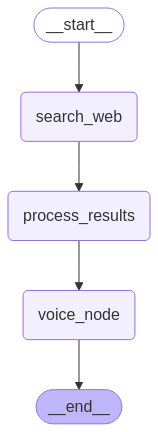

In [21]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        version1.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [26]:
version1.podcast_topic("gemini")

🔊 Audio should be playing now. If you don't hear anything, check your volume settings.
{'query': 'gemini', 'search_results': [{'title': 'Gemini (astrology) - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Gemini_(astrology)', 'content': 'AriesTaurusGeminiCancerLeoVirgoLibraScorpioSagittariusCapricornAquariusPisces\nSymbols\nPlanetMetals\nvte\nGemini (♊︎; /ˈdʒɛmɪnaɪ/ JEM-in-eye [2] Greek: Δίδυμοι, romanized:\xa0Dídymoi, Latin for "twins") is the third astrological sign in the zodiac. Under the tropical zodiac, the sun transits this sign between about May 21 to June 21.[3] Gemini is represented by the twins, Castor and Pollux,[4] known as the Dioscuri in Greek mythology. It is known as a positive, mutable sign.\nMythology[edit] [...] In Greek mythology, Gemini is associated with the myth of Castor and Pollux, a pair of twins conceived by different fathers. Zeus, who seduced Leda and conceived Pollux while Tyndareus, the king of Sparta and Leda\'s husband, conceived Castor. When Castor

"PodCast_convo: Welcome back to Astrological Insights! Today, we're diving into Gemini, the sign of the Twins. \n\n**Step 1:** Understanding the Basics  \nGemini spans from May 21 to June 21 and is represented by Castor and Pollux. It's known for its mutable air qualities, making Geminis adaptable and communicative.\n\n**Step 2:** Noting its Significance  \nIn astrology, Geminis are ruled by Mercury, emphasizing their curious and vibrant nature. In the cosmos, the constellation Gemini lies between Taurus and Cancer and boasts stars like Pollux and Castor, which are known for their distinct brightness.\n\n**Final Thought:** Fun Fact!  \nNASA's Project Gemini was named after this zodiac sign, showcasing the dynamism of collaboration, as the spacecraft carried two astronauts at a time, much like the twins themselves. \n\nThat's your quick dive into the world of Gemini! Catch you next time!"

Build Our version 2: ReAct Agent + Search Tool + Voice Tool


In [53]:
from typing import Dict, List, Optional, Any, Annotated
import io
import contextlib
from langchain_core.tools import tool
from langchain.agents import AgentExecutor, create_react_agent
from google.colab import userdata
from langchain_openai import ChatOpenAI
import os
from langchain import hub

os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

def init_chat_model(model_name, model_provider="openai"):
    if model_provider == "openai":
        return ChatOpenAI(model=model_name, api_key = userdata.get('OPENAI_API_KEY'))
    else:
        raise ValueError(f"Unsupported model provider: {model_provider}")


class ReActAgent():
    """ReAct agent implementation for podcast generation"""

    def __init__(self):
        self.llm = None
        self.tools = []
        self.graph = None
        self.llm_prompt = None
        self.model_name = "gpt-4o"
        self.model_provider = "openai"

    def initialize(self) -> None:
        """Initialize components for the tool-using agent."""
        # Initialize Gemini model properly
        self.llm = init_chat_model("gpt-4o", model_provider="openai")

        # Create tools
        self.tools = self._create_tools()

        # Create the ReAct agent with system_prompt instead of prompt
        base_prompt = hub.pull("langchain-ai/react-agent-template")
        prompt = base_prompt.partial(instructions=self.llm_prompt, tools=self.tools, tool_names =["TavilySearchResults","voice_tool"], input = '', agent_scratchpad= '')
        agent = create_react_agent(
            llm=self.llm,
            tools=self.tools,
            prompt=prompt
        )
        self.graph = AgentExecutor(agent=agent, tools=self.tools, verbose=True)

    def _create_tools(self) -> List[Any]:
        """Create and return the list of tools for the agent."""
        search_tool = TavilySearchResults(
            api_key=userdata.get('TAVILY_API_KEY'),
            max_results=2,
            include_answer=True,
            include_raw_content=False,
            include_images=False,
            search_depth="advanced"
        )

        @tool
        def voice_tool(text_input: str) -> str:
            """Generate speech from text using ElevenLabs API.
            Pass the text you want converted to speech."""
            return get_voice_tool(text_input)

        return [search_tool, voice_tool]

    def podcast_topic(self, podcast_topic: str) -> str:
        """Creates a podcast from the given topic"""
        try:
            # Invoke the agent with the topic
            result = self.graph.invoke({"input": podcast_topic})

            # The result typically contains the agent's final response
            if isinstance(result, dict) and "output" in result:
                return result["output"]
            else:
                print(result)  # Print raw result for debugging
                return f"Podcast created with ReAct agent"
        except Exception as e:
            print(f"Detailed error: {str(e)}")
            return f"Error generating podcast: {str(e)}"



In [56]:
version2 = ReActAgent()
version2.llm_prompt = """You are an AI podcast host specialized in creating informative podcasts.
When given a topic, follow these steps:
1. Use the search_tool to gather recent information about the topic
2. Organize the content in a 3-Steps, 2-Types, 1-Thing framework:
   - 3 Steps: Three key actions or processes related to the topic
   - 2 Types: Two important categories or classifications within the topic
   - 1 Thing: The single most important takeaway
3. Keep your content under 45 seconds when spoken
4. Craft your response as a complete podcast script
5. At the end, use the voice_tool with your complete podcast script to generate audio. Always use the voice tool

Remember to make the content engaging, informative, and concise.
"""
version2.initialize()

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:271: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


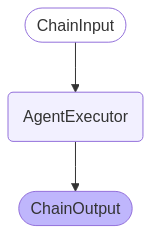

In [57]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        version2.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [59]:
version2.podcast_topic("gemini")



> Entering new AgentExecutor chain...
To create an informative podcast about "Gemini," I'm going to gather recent information. Let's get started.

Thought: Do I need to use a tool? Yes
Action: tavily_search_results_json
Action Input: Gemini recent news 2023[{'title': 'Gemini Crypto News & Press Mentions', 'url': 'https://www.gemini.com/news', 'content': "Support\n\nSign in\n\nPress Contact: Natalie Rix | press@gemini.com\n\nDownload Our Press Kit\n\nGemini Crypto News & Press Mentions\n\nSep 27, 2023  |  Shashank Bhardwaj  |  Forbes India\n\nCrypto exchange Gemini invests $24 million in India\n\nRead More\n\nSep 26, 2023  |  Poulami Saha  |  Financial Express\n\nGemini to invest $24 million in Gurgaon engineering hub\n\nRead More\n\nJun 7, 2023  |  Michelle Martin  |  MoneyFM\n\nMoney and Me: Why the Billionaire Bitcoin Winklevoss twins are betting on Asia\n\nRead More [...] Jun 7, 2023  |  Claire Huang  |  The Straits Times\n\nWinklevoss twins look to expand their crypto business in

🔊 Audio should be playing now. If you don't hear anything, check your volume settings.
NoneDetailed error: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `The podcast audio has been generated. You can listen to the podcast about Gemini's recent developments by accessing the audio file. If you need further assistance or another topic exploration, feel free to ask!`
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 


"Error generating podcast: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `The podcast audio has been generated. You can listen to the podcast about Gemini's recent developments by accessing the audio file. If you need further assistance or another topic exploration, feel free to ask!`\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE "